 # Preparing

### Import Library

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd
import plotly.express as px 
from plotly.subplots import make_subplots 
import plotly.graph_objects as go
import plotly.figure_factory as ff
import glob
import os
from sklearn.impute import KNNImputer
plt.style.use('ggplot')
pd.set_option('display.max_columns', False)
seed= 92

In [2]:
df = pd.read_csv('data_finish.csv')
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_cols = df.select_dtypes(include=numerics).columns
notNum_cols = df.select_dtypes(exclude=numerics).columns
print("Number Columns : ", num_cols)
print("Not Number Columns: ", notNum_cols)

Number Columns :  Index(['Tn', 'Tx', 'Tavg', 'RH_avg', 'RR', 'ss', 'ff_x', 'ddd_x', 'ff_avg',
       'station_id', 'flood'],
      dtype='object')
Not Number Columns:  Index(['date', 'ddd_car', 'station_name', 'region_name'], dtype='object')


### Remove station_id and name from index

In [3]:
num_cols=num_cols.delete([9,10])
print("Number Columns : ", num_cols)
notNum_cols = notNum_cols.delete([0,2])
print("Not Number Columns: ", notNum_cols)

Number Columns :  Index(['Tn', 'Tx', 'Tavg', 'RH_avg', 'RR', 'ss', 'ff_x', 'ddd_x', 'ff_avg'], dtype='object')
Not Number Columns:  Index(['ddd_car', 'region_name'], dtype='object')


# Data Cleansing

### Handing outliers

In [4]:
df.isnull().sum()

date               0
Tn               312
Tx               213
Tavg              46
RH_avg            52
RR              2315
ss              1259
ff_x              22
ddd_x             22
ff_avg            93
ddd_car          101
station_id         0
station_name       0
region_name        0
flood              0
dtype: int64

In [5]:
fig = make_subplots(rows=2, cols=4,vertical_spacing=0.05)
indexCol = 0
for i in range(1,3): 
    for j in range(1,5):         
        fig.add_trace(go.Box(y = df[num_cols[indexCol]],name= num_cols[indexCol]),row=i, col=j)
        indexCol+=1


fig.update_layout(height=1400, width=700,margin=dict(l=20, r=20, t=20, b=20))
fig.show()

In [6]:
columns = ['Tn', 'Tx', 'Tx', 'RH_avg', 'ff_avg', 'ff_x']
minValues =[19,19,19, 0, 1, 1] 
maxValues = [40,40,40, 100, 36, 36] 

In [7]:
def remove_outliers(df, columns , maxVal, minVal): 
    temp =[]
    for i in range(len(df)): 
        # print(i)
        for j in range(len(columns)):
            # print(minVal[j])
            # print(maxVal[j])
            # print(df[columns[j]][i])
            if( minVal[j]>= df[columns[j]][i] or df[columns[j]][i] >= maxVal[j]) : 
                # print(df[columns][i])
                temp.append(i)
    print(temp)
    x = 0
    aaa = df
    for i in temp:
        print(aaa.head()) 
        aaa = aaa.drop( i )
    return aaa

In [8]:
from pandas.api.types import is_numeric_dtype

def dropOutliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1

    mul = 1.5
    lowerbound = q1 - mul * iqr
    higherbound = q3 + mul * iqr
    # print(lowerbound, higherbound)
    return series[~((series < lowerbound) | (series > higherbound))]

def dropOutliersDataframe(df):
    global num_cols
    df_no_outliers = df.copy()
    for column in df.columns:
        if(is_numeric_dtype(df[column])):
            df_no_outliers[column] = dropOutliers(df_no_outliers[column])

            before = len(df[column])
            after = len(df_no_outliers[column])
            print(column + ": ", end="")
            print("{:.2f}".format( before ), end="")
            print(" => ", end="")
            print("{:.2f}".format( after ), end="")
            print(f" ({after-before}) ")
    return df_no_outliers

df_noOutliers = df.copy().drop(['RR','flood','station_id','station_name'],axis=1)
df_noOutliers = dropOutliersDataframe(df_noOutliers)
df_noOutliers = df_noOutliers.join(df[['RR','flood']])

Tn: 6308.00 => 6308.00 (0) 
Tx: 6308.00 => 6308.00 (0) 
Tavg: 6308.00 => 6308.00 (0) 
RH_avg: 6308.00 => 6308.00 (0) 
ss: 6308.00 => 6308.00 (0) 
ff_x: 6308.00 => 6308.00 (0) 
ddd_x: 6308.00 => 6308.00 (0) 
ff_avg: 6308.00 => 6308.00 (0) 


In [9]:
df_noOutliers.head()

,date,Tn,Tx,Tavg,RH_avg,ss,ff_x,ddd_x,ff_avg,ddd_car,region_name,RR,flood
0,2016-01-01,26.0,34.8,28.6,81.0,5.8,5.0,280.0,2.0,S,Jakarta Selatan,NaN,0
1,2016-01-02,25.6,33.2,27.0,88.0,8.7,4.0,290.0,2.0,W,Jakarta Selatan,1.6,1
2,2016-01-03,24.4,34.9,28.1,80.0,5.4,4.0,280.0,2.0,SW,Jakarta Selatan,33.8,1
3,2016-01-04,24.8,33.6,29.2,81.0,6.6,3.0,200.0,1.0,S,Jakarta Selatan,NaN,0
4,2016-01-05,25.8,33.6,26.7,91.0,3.2,3.0,180.0,1.0,S,Jakarta Selatan,NaN,0


In [10]:
fig = make_subplots(rows=2, cols=4,vertical_spacing=0.05,)
indexCol = 0
for i in range(1,3): 
    for j in range(1,5):         
        fig.add_trace(go.Box(y = df_noOutliers[num_cols[indexCol]],name= num_cols[indexCol]),row=i, col=j)
        indexCol+=1


fig.update_layout(height=1400, width=700,margin=dict(l=20, r=20, t=20, b=20))
fig.show()

### Handling NaN value

In [11]:
df_noOutliers.isnull().sum()

date              0
Tn              368
Tx              473
Tavg            159
RH_avg           73
ss             1259
ff_x            933
ddd_x            22
ff_avg          201
ddd_car         101
region_name       0
RR             2315
flood             0
dtype: int64

In [12]:
df_number = df_noOutliers[num_cols]
imp = KNNImputer(n_neighbors=5, weights="uniform")
imputed_data = imp.fit_transform(df_number)
df_temp= pd.DataFrame(imputed_data,columns=num_cols)
df_temp.head()

,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg
0,26.0,34.8,28.6,81.0,10.14,5.8,5.0,280.0,2.0
1,25.6,33.2,27.0,88.0,1.60,8.7,4.0,290.0,2.0
2,24.4,34.9,28.1,80.0,33.80,5.4,4.0,280.0,2.0
3,24.8,33.6,29.2,81.0,21.40,6.6,3.0,200.0,1.0
4,25.8,33.6,26.7,91.0,6.64,3.2,3.0,180.0,1.0


In [13]:
from sklearn.impute import SimpleImputer
df_notNumber= df[notNum_cols]
imp = SimpleImputer(strategy='most_frequent', fill_value=str)
df_notNumber= imp.fit_transform(df_notNumber)
df_notNumber= pd.DataFrame(df_notNumber, columns=notNum_cols )
df_notNumber.head()

,ddd_car,region_name
0,S,Jakarta Selatan
1,W,Jakarta Selatan
2,SW,Jakarta Selatan
3,S,Jakarta Selatan
4,S,Jakarta Selatan


In [14]:
df_fixed =df_temp.join(df_notNumber)
print(df_fixed.isnull().sum())

Tn             0
Tx             0
Tavg           0
RH_avg         0
RR             0
ss             0
ff_x           0
ddd_x          0
ff_avg         0
ddd_car        0
region_name    0
dtype: int64


In [15]:
df_fixed = df_fixed.join(df['flood'])

In [16]:
df_fixed.head()

,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,ddd_car,region_name,flood
0,26.0,34.8,28.6,81.0,10.14,5.8,5.0,280.0,2.0,S,Jakarta Selatan,0
1,25.6,33.2,27.0,88.0,1.60,8.7,4.0,290.0,2.0,W,Jakarta Selatan,1
2,24.4,34.9,28.1,80.0,33.80,5.4,4.0,280.0,2.0,SW,Jakarta Selatan,1
3,24.8,33.6,29.2,81.0,21.40,6.6,3.0,200.0,1.0,S,Jakarta Selatan,0
4,25.8,33.6,26.7,91.0,6.64,3.2,3.0,180.0,1.0,S,Jakarta Selatan,0


# EDA


### Heatmap

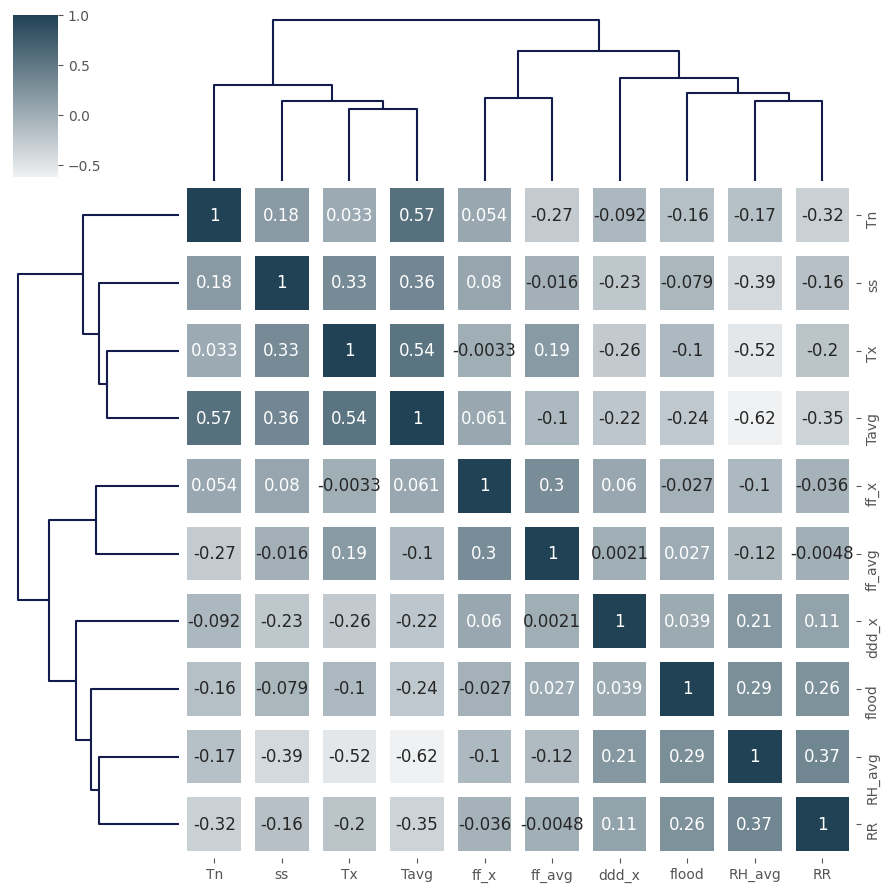

In [17]:
DF_CMAP = sns.light_palette("#204254", as_cmap=True)  # type: ignore
sns.clustermap(
    df_fixed.corr(numeric_only=True),
    linewidth=10,
    annot=True,
    tree_kws={"linewidths": 1.5, "color": "#141B4D"},
    annot_kws={"fontsize": 12},
    figsize=(9, 9),
    cmap = DF_CMAP, 
)
plt.show()

In [18]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_cols_up = df_fixed.select_dtypes(include=numerics).columns

### Melihat Relasi Suhu(Tn,Tavg,Tx) dan Curah Hujan(RR)

In [77]:
# temp=['Tx','Tn','Tavg']
# fig = make_subplots(cols=3,vertical_spacing=0.05)
# indexCol = 0
# for i in range(1,4): 
#         fig.add_trace(go.Scatter(y=df_fixed['RR'] , x = df_fixed[temp[indexCol]],mode='markers',marker_color =df_fixed['flood']),col=i,row=1)
#         indexCol+=1


# fig.update_layout(height=600, width=1600)
# fig.update_traces(textposition="bottom right")
# for i in range(1,4): 
#         fig['layout']['xaxis{0}'.format(i)]['title']= temp[i-1]
#         fig['layout']['yaxis{0}'.format(i)]['title']= 'RR'
# fig.show()

In [94]:
temp=['Tx','Tn','Tavg']
df_fixed["flood"] = df_fixed["flood"].astype(str)
fig1 = px.scatter(df_fixed,x='Tx',y='RR', color='flood')
fig2 = px.scatter(df_fixed,x='Tn',y='RR', color='flood')
fig3 = px.scatter(df_fixed,x='Tavg',y='RR', color='flood')
fig = make_subplots(rows=1, cols=3,
                    column_titles = temp,
                    row_titles = ['RR'],
                    shared_yaxes=False)
fig.add_trace(fig1['data'][0], row=1, col=1)
fig.add_trace(fig1['data'][1], row=1, col=1)

fig.add_trace(fig2['data'][0], row=1, col=2)
fig.add_trace(fig2['data'][1], row=1, col=2)

fig.add_trace(fig3['data'][0], row=1, col=3)
fig.add_trace(fig3['data'][1], row=1, col=3)
names = set()
fig.for_each_trace(
    lambda trace:
        trace.update(showlegend=False)
        if (trace.name in names) else names.add(trace.name))
fig.update_layout(
    title=dict(
        text="Grafik Relasi Suhu dan Curah Hujan",
        font=dict(size=24),
        x=0.5,
        xref="paper"
    )
)
fig.show()

Berdasarkan heatmap dan grafik di atas, bisa diperhatikan bahwa pada kebanyakan kasus curah hujan berlawanan dengan suhu yang berarti apabila curah hujan tinggi maka suhu juga menjadi rendah hal ini didukung juga dengan banjir yang terjadi pada saat curah hujan tinggi yang menandakan bahwa hujan terjadi pada saat tersebut

### Melihat Relasi Banjir dengan Curah Hujan

In [113]:
survived_mask = df_fixed['flood'] == '1'
survived = df_fixed.loc[survived_mask,'RR']
nonsurv = df_fixed.loc[~survived_mask,'RR']

In [117]:
dataset= [survived,nonsurv]
group_labels = ['1','0']
fig = ff.create_distplot(dataset, group_labels=group_labels, show_hist=False)
fig.update_layout(
    title=dict(
        text="Grafik Distribusi Curah Hujan",
        font=dict(size=24),
        x=0.5,
        xref="paper"
    )
)

Berdasarkan hasil dari heatmap serta visualisasi di atas, diketahui bahwa banjir tidak hanya terjadi pada curah hujan yang tinggi tetapi juga pada curah hujan yang rendah hal ini dikarenakan banjir bisa bertahan hingga beberapa hari hingga benar benar kering. Tetapi pada beberapa kasus ekstrem dimana curah hujan melebihi 150 banjir pasti terjadi hal ini bisa dilihat pada grafik bagian atas tepatnya grafik keduanya. Selain itu, berdasarkan distribusi di atas bisa dilihat bahwa antara curah hujan 0-50 lebih banyak tidak terjadi banjir